# <span style = "background-color: #FFDDDD"> 없다면 어떻게 될까? (ResNet Ablation Study)</span>

⭐️ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가? 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.  
⭐️구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가? tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.  
⭐️Ablation Study 결과가 바른 포맷으로 제출되었는가? ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

---
## <span style = "background-color: #FFFFDD"> 🍒 Environment Setting</span>

### <span style = "background-color: #F0E9FF"> 1. Import libraries & packages </span>

In [1]:
# data handling
import numpy as np


# visualization
import matplotlib.pyplot as plt


# dataset API
import urllib3
import tensorflow_datasets as tfds


# ML/DL 
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models

# ignore warning messages for corrupted image data files
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow_datasets")

### <span style = "background-color: #F0E9FF"> 2. Define constants</span>

In [2]:
# image data configurations
CAT = 0
DOG = 1

TOTAL_CLASSES_CNT = 2

In [3]:
# machine learning configurations
IMG_SIZE = 224

TRAIN_SAMPLES_CNT = 17446
TEST_SAMPLES_CNT = 5816

BATCH_SIZE = 64
EPOCHS = 5

### <span style = "background-color: #F0E9FF"> 3. Define frequently used methods</span>

In [4]:
DIVIDER_LENGTH = 80

def print_single_divider(length = DIVIDER_LENGTH):
    print("-" * DIVIDER_LENGTH)

def print_double_divider(length = DIVIDER_LENGTH):
    print("=" * DIVIDER_LENGTH)

---
## <span style = "background-color: #FFFFDD"> 🍒 Data Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Load dataset</span>

In [5]:
# set dataset url download configurations
urllib3.disable_warnings()

In [6]:
# set dataset url
setattr(tfds.image_classification.cats_vs_dogs,
        "_URL","https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [7]:
(ds_train, ds_test), ds_info = tfds.load("cats_vs_dogs",
                                         split=["train[:75%]", "train[75%:]"],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True,                                        )

print("The dataset has been loaded successfully!")

The dataset has been loaded successfully!


### <span style = "background-color: #F0E9FF"> 2. Preview data</span>

**2-1. Get data information**

In [8]:
# check the dataset feature information
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [9]:
# check the number of train/test data samples
print(">>> The number of train data samples : ", tf.data.experimental.cardinality(ds_train))
print(">>> The number of test data samples  : ", tf.data.experimental.cardinality(ds_test))

>>> The number of train data samples :  tf.Tensor(17446, shape=(), dtype=int64)
>>> The number of test data samples  :  tf.Tensor(5816, shape=(), dtype=int64)


In [10]:
# check the label information
print(">>> The number of labels             : ", ds_info.features["label"].num_classes)
print(">>> List of labels                   : ", ds_info.features["label"].names)

>>> The number of labels             :  2
>>> List of labels                   :  ['cat', 'dog']


**2-2. Preview image data samples**

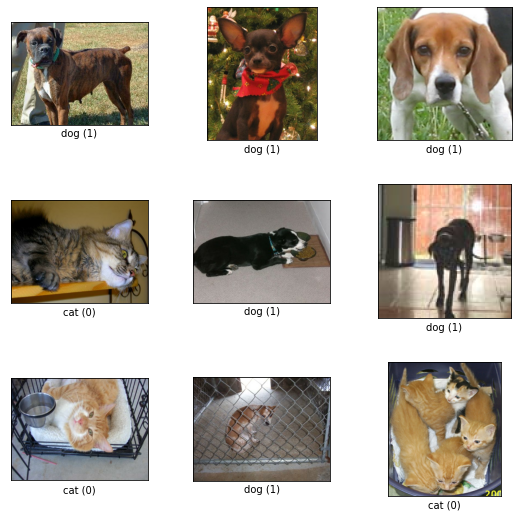

In [11]:
# preview TRAIN image data samples
preview_train = tfds.show_examples(ds_train, ds_info)
preview_train.show()

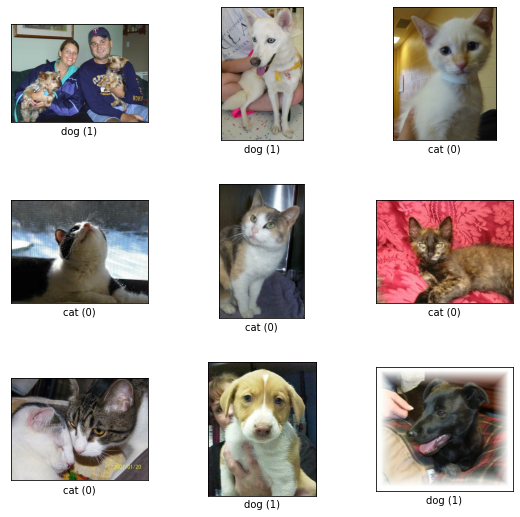

In [12]:
# preivew TEST image data samples
preview_test = tfds.show_examples(ds_test, ds_info)
preview_test.show()

### <span style = "background-color: #F0E9FF"> 3. Pre-process data</span>

**3-1. Define pre-processing methods**

In [13]:
# normalization method
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [14]:
# pipelline method for normalization & data usage configuration setting
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    # normalization
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    
    
    # data usage configurations
    ds = ds.batch(batch_size)
    
    if not is_test: # set additional configurations for training data (not test) 
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    
    return ds

**3-2. Pre-process data**

In [15]:
# pre-process TRAIN data
ds_train = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=BATCH_SIZE)
print("Pre-process for TRAIN data has finished successfully!")

# pre-process TEST data
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)
print("Pre-process for TEST data has finished successfully!")

Pre-process for TRAIN data has finished successfully!
Pre-process for TEST data has finished successfully!


---
## <span style = "background-color: #FFFFDD"> 🍒 Model Design</span>

### <span style = "background-color: #F0E9FF"> 1. Design model structure</span>

**1-1. Comparison between plain network & ResNet with 34-layer**

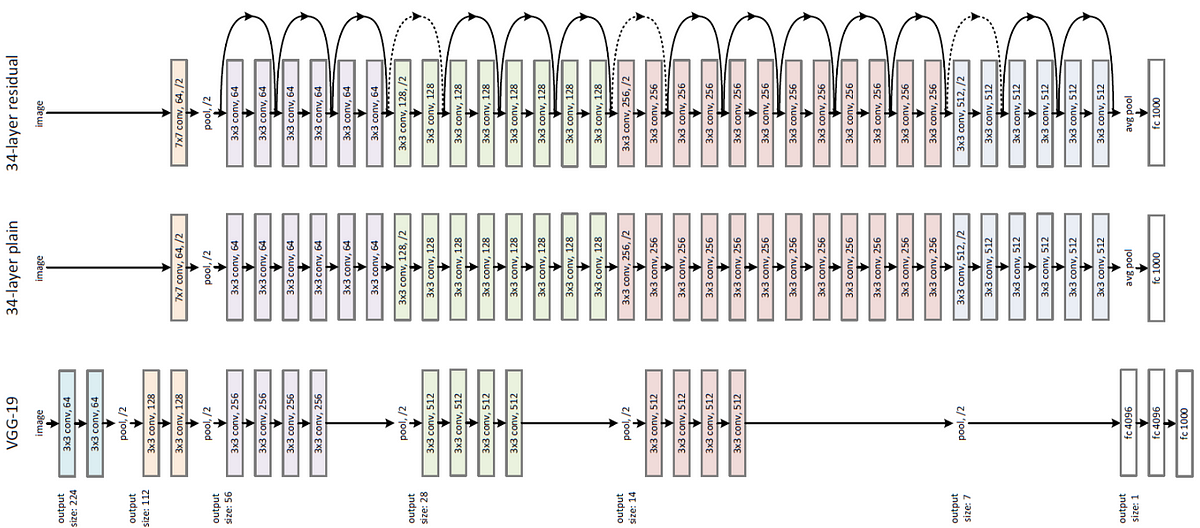

**1-2. Comparison between 34-layer & 50-layer ResNet**

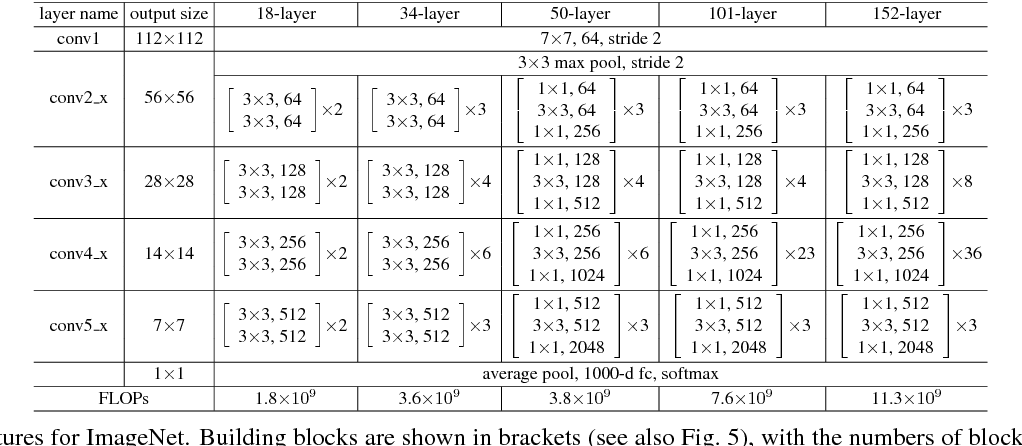

**1-3. Analysis of basic layer block of ResNet**

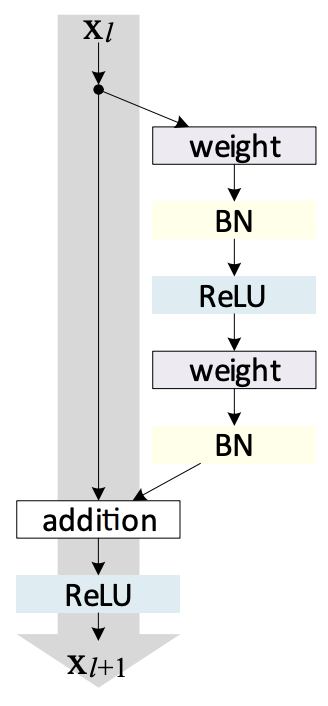

### <span style = "background-color: #F0E9FF"> 2. Define the layer block</span>

In [16]:
def build_resnet_block(inputs, channels, resnet_layer, down_sampling=False, shortcut=False):
    KERNEL_INIT = "he_normal"
    
    strides = [2, 1] if down_sampling else [1, 1]
    
    padding_opt = "same"
    kernel_size = (3, 3)
    
    if resnet_layer > 34:
        padding_opt = "valid"
        kernel_size = (1, 1)

    
    

    # input layer
    x = inputs
    
    
    # 1st convolution layer
    x = layers.Conv2D(channels, strides=strides[0], kernel_size=kernel_size, padding=padding_opt, kernel_initializer=KERNEL_INIT)(x)
    x = layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    
    # additional layer for large ResNet (bigger than 34)
    if resnet_layer > 34:
        x = layers.Conv2D(channels, strides=strides[1], kernel_size=(3,3), padding="same", kernel_initializer=KERNEL_INIT)(x)
        x = layers.BatchNormalization()(x)
        x = tf.nn.relu(x)

    # 2nd convolution layer
    if resnet_layer > 34:
        channels = channels * 4
    x = layers.Conv2D(channels, strides=strides[1], kernel_size=kernel_size, padding=padding_opt, kernel_initializer=KERNEL_INIT)(x)
    x = layers.BatchNormalization()(x)

    
    
    if shortcut == True:    # ResNet with shortcut connection
        # shortcut connection
        if down_sampling:
            res = layers.Conv2D(channels, strides=2, kernel_size=(1,1), kernel_initializer=KERNEL_INIT, padding="same")(inputs)
            res = layers.BatchNormalization()(res)
        else:
            res = inputs

        # resize shortcut connection if needed
        if res.shape[-1] != x.shape[-1]:
            res = layers.Conv2D(x.shape[-1], kernel_size=(1,1), strides=strides[0], padding="same", kernel_initializer=KERNEL_INIT)(res)
            res = layers.BatchNormalization()(res)

        # merge with shortcut connection
        x = layers.add([x, res])
    
    
    x = tf.nn.relu(x)
    
    return x

### <span style = "background-color: #F0E9FF"> 3. Define full model structure</span>

**3-1. Define ResNet model method**

In [17]:
def build_resnet(resnet_layer=34, input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=TOTAL_CLASSES_CNT, shortcut=True):
    # input layer
    inputs = layers.Input(shape=input_shape)
    
    # 1st layer
    x = layers.Conv2D(64, (7,7), strides=2, padding="same", kernel_initializer="he_normal")(inputs)
    x = layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)
    
    
    
    # 2nd ~ 5th layer (repetition of residual blocks)
    block_repeat = {18: [2, 2, 2, 2],
                    34: [3, 4, 6, 3],
                    50: [3, 4, 6, 3],
                    101: [3, 4, 23, 3],
                    152: [3, 8, 36, 3]}
    channels = [64, 128, 256, 512]
    
    for i in range(4):
        for j in range(block_repeat[resnet_layer][i]):
            down_sampling = False
            if i != 0 and j == 0:
                down_sampling = True
                
            x = build_resnet_block(x, resnet_layer=resnet_layer, channels=channels[i], down_sampling=down_sampling, shortcut=shortcut)
        
    
    # output layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation="softmax")(x)
    outputs = x
    
    
    # return model
    model = models.Model(inputs, outputs)
    return model

**3-2. Define plain network (ResNet without skip connection) model method**

In [18]:
def build_plainnet(resnet_layer=34, input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=TOTAL_CLASSES_CNT):
    model = build_resnet(resnet_layer=resnet_layer, input_shape=input_shape, num_classes=num_classes, shortcut=False)
    return model

**3-3. Check valideness of model constructure**  
프로젝트 노드의 예시와 동일한 model instance를 생성하여, 노드 예시와 layer 구조를 비교 (ResNet-34, ResNet-50이 올바르게 잘 구현되었는지 확인) 

In [19]:
# ResNet-34 sample with same parameters suggested in programming guide
resnet_34_test = build_resnet(resnet_layer=34, input_shape=(32, 32, 3), num_classes=10)
resnet_34_test.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

💡 프로젝트 노드 예시와 같이 CIFAR-10 기준으로 모델 객체 생성 결과, 모델 구조가 프로젝트 노드에 제시된 구조와 동일함을 확인하였다.  

```
Total params: 21,315,338
Trainable params: 21,298,314
Non-trainable params: 17,024
```

In [20]:
# ResNet-50 sample with same parameters suggested in programming guide
resnet_50_test = build_resnet(resnet_layer=50, input_shape=(32, 32, 3), num_classes=10)
resnet_50_test.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
tf.nn.relu_33 (TFOpLambda)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

💡 프로젝트 노드 예시와 같이 CIFAR-10 기준으로 모델 객체 생성 결과, 모델 구조가 프로젝트 노드에 제시된 구조와 동일함을 확인하였다.  
프로젝트 노드 예시에서는 마지막 2개의 레이어 (pooling layer, dense layer) 가 구현되지 않았으므로, 파라미터의 갯수가 다소 차이가 난다. 

```
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
```

### <span style = "background-color: #F0E9FF"> 4. Generate model instances</span>

**4-1. Generate ResNet-34 model instance**

In [21]:
resnet_34 = build_resnet(resnet_layer=34, input_shape=(IMG_SIZE, IMG_SIZE,3))
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_89 (BatchNo (None, 112, 112, 64) 256         conv2d_89[0][0]                  
__________________________________________________________________________________________________
tf.nn.relu_82 (TFOpLambda)      (None, 112, 112, 64) 0           batch_normalization_89[0][0]     
____________________________________________________________________________________________

**4-2. Generate ResNet-50 model instance**

In [22]:
resnet_50 = build_resnet(resnet_layer=50, input_shape=(IMG_SIZE, IMG_SIZE,3))
resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_125 (BatchN (None, 112, 112, 64) 256         conv2d_125[0][0]                 
__________________________________________________________________________________________________
tf.nn.relu_115 (TFOpLambda)     (None, 112, 112, 64) 0           batch_normalization_125[0][0]    
____________________________________________________________________________________________

**4-3. Generate plain-34 model instance (ResNet-34 without shortcut connection)**

In [23]:
plainnet_34 = build_plainnet(resnet_layer=34, input_shape=(IMG_SIZE, IMG_SIZE,3))
plainnet_34.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_178 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
tf.nn.relu_164 (TFOpLambda)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_179 (Bat (None, 56, 56, 64)        256 

**4-3. Generate plain-50 model instance (ResNet-34 without shortcut connection)**

In [24]:
plainnet_50 = build_plainnet(resnet_layer=50, input_shape=(IMG_SIZE, IMG_SIZE,3))
plainnet_50.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_211 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
tf.nn.relu_197 (TFOpLambda)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_212 (Bat (None, 56, 56, 64)        256 

---
## <span style = "background-color: #FFFFDD"> 🍒 Experiments</span>

In [25]:
experiments_dict = {"ResNet-34": {"model": resnet_34, "history": None},
                    "ResNet-50": {"model": resnet_50, "history": None},
                    "plain-34": {"model": plainnet_34, "history": None},
                    "plain-50": {"model": plainnet_50, "history": None}}

In [26]:
# compile and training with each model
for model_name in experiments_dict.keys():
    model = experiments_dict[model_name]["model"]
    
    print("Training for " + model_name + " has started...")
    print_single_divider()
    
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
                  metrics=["accuracy"],)

    experiments_dict[model_name]["history"] = model.fit(ds_train,
                                                       steps_per_epoch=int(TRAIN_SAMPLES_CNT/BATCH_SIZE),
                                                       validation_steps=int(TEST_SAMPLES_CNT/BATCH_SIZE),
                                                       epochs=EPOCHS,
                                                       validation_data=ds_test,
                                                       verbose=1,
                                                       use_multiprocessing=True,)
    
    print_single_divider()
    print("Training for " + model_name + " model is finished successfully!")
    print_double_divider()

Training for ResNet-34 has started...
--------------------------------------------------------------------------------
Epoch 1/5


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 43/272 [===>..........................] - ETA: 1:16 - loss: 0.6889 - accuracy: 0.5716

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 46/272 [====>.........................] - ETA: 1:15 - loss: 0.6878 - accuracy: 0.5713

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 53/272 [====>.........................] - ETA: 1:13 - loss: 0.6864 - accuracy: 0.5740

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:08 - loss: 0.6831 - accuracy: 0.5754

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 1:08 - loss: 0.6826 - accuracy: 0.5772

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


156/272 [================>.............] - ETA: 40s - loss: 0.6604 - accuracy: 0.6084

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


174/272 [==================>...........] - ETA: 34s - loss: 0.6549 - accuracy: 0.6141

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


210/272 [======================>.......] - ETA: 21s - loss: 0.6493 - accuracy: 0.6211

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6401 - accuracy: 0.6317

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 174s 387ms/step - loss: 0.6401 - accuracy: 0.6317 - val_loss: 1.0477 - val_accuracy: 0.4993
Epoch 2/5
 42/272 [===>..........................] - ETA: 1:20 - loss: 0.6054 - accuracy: 0.6786

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 48/272 [====>.........................] - ETA: 1:18 - loss: 0.6075 - accuracy: 0.6751

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 53/272 [====>.........................] - ETA: 1:16 - loss: 0.6065 - accuracy: 0.6778

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 1:12 - loss: 0.6027 - accuracy: 0.6747

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 1:11 - loss: 0.6013 - accuracy: 0.6757

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


156/272 [================>.............] - ETA: 41s - loss: 0.5873 - accuracy: 0.6868

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


175/272 [==================>...........] - ETA: 34s - loss: 0.5877 - accuracy: 0.6871

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


211/272 [======================>.......] - ETA: 21s - loss: 0.5847 - accuracy: 0.6920

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5771 - accuracy: 0.6969

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 392ms/step - loss: 0.5771 - accuracy: 0.6969 - val_loss: 0.9851 - val_accuracy: 0.5486
Epoch 3/5
 42/272 [===>..........................] - ETA: 1:20 - loss: 0.5380 - accuracy: 0.7340

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 48/272 [====>.........................] - ETA: 1:18 - loss: 0.5408 - accuracy: 0.7318

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 54/272 [====>.........................] - ETA: 1:16 - loss: 0.5426 - accuracy: 0.7265

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:11 - loss: 0.5443 - accuracy: 0.7249

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:10 - loss: 0.5417 - accuracy: 0.7271

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


158/272 [================>.............] - ETA: 40s - loss: 0.5278 - accuracy: 0.7353

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


176/272 [==================>...........] - ETA: 33s - loss: 0.5267 - accuracy: 0.7364

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


213/272 [======================>.......] - ETA: 20s - loss: 0.5213 - accuracy: 0.7416

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.7440

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 387ms/step - loss: 0.5169 - accuracy: 0.7440 - val_loss: 0.6770 - val_accuracy: 0.6422
Epoch 4/5
 43/272 [===>..........................] - ETA: 1:20 - loss: 0.4832 - accuracy: 0.7682

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 50/272 [====>.........................] - ETA: 1:17 - loss: 0.4816 - accuracy: 0.7650

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 55/272 [=====>........................] - ETA: 1:15 - loss: 0.4822 - accuracy: 0.7628

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:11 - loss: 0.4808 - accuracy: 0.7654

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:10 - loss: 0.4777 - accuracy: 0.7683

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


159/272 [================>.............] - ETA: 39s - loss: 0.4676 - accuracy: 0.7749

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


177/272 [==================>...........] - ETA: 33s - loss: 0.4652 - accuracy: 0.7760

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


213/272 [======================>.......] - ETA: 20s - loss: 0.4628 - accuracy: 0.7786

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.7852

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 387ms/step - loss: 0.4538 - accuracy: 0.7852 - val_loss: 0.5620 - val_accuracy: 0.7316
Epoch 5/5
 45/272 [===>..........................] - ETA: 1:19 - loss: 0.4062 - accuracy: 0.8139

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 50/272 [====>.........................] - ETA: 1:18 - loss: 0.4106 - accuracy: 0.8122

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 56/272 [=====>........................] - ETA: 1:15 - loss: 0.4061 - accuracy: 0.8156

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 1:11 - loss: 0.4053 - accuracy: 0.8166

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:10 - loss: 0.4044 - accuracy: 0.8174

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


159/272 [================>.............] - ETA: 39s - loss: 0.3949 - accuracy: 0.8239

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 33s - loss: 0.3950 - accuracy: 0.8239

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


214/272 [======================>.......] - ETA: 20s - loss: 0.3908 - accuracy: 0.8246

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.3825 - accuracy: 0.8290

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 388ms/step - loss: 0.3825 - accuracy: 0.8290 - val_loss: 1.4568 - val_accuracy: 0.5724
--------------------------------------------------------------------------------
Training for ResNet-34 model is finished successfully!
Training for ResNet-50 has started...
--------------------------------------------------------------------------------
Epoch 1/5


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 30/272 [==>...........................] - ETA: 2:42 - loss: 0.7693 - accuracy: 0.5432

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 38/272 [===>..........................] - ETA: 2:39 - loss: 0.7635 - accuracy: 0.5403

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 47/272 [====>.........................] - ETA: 2:34 - loss: 0.7555 - accuracy: 0.5372

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 52/272 [====>.........................] - ETA: 2:31 - loss: 0.7518 - accuracy: 0.5394

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 55/272 [=====>........................] - ETA: 2:29 - loss: 0.7508 - accuracy: 0.5389

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


156/272 [================>.............] - ETA: 1:18 - loss: 0.7219 - accuracy: 0.5506

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


175/272 [==================>...........] - ETA: 1:05 - loss: 0.7175 - accuracy: 0.5537

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


212/272 [======================>.......] - ETA: 40s - loss: 0.7139 - accuracy: 0.5592

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.7065 - accuracy: 0.5649

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 230s 747ms/step - loss: 0.7065 - accuracy: 0.5649 - val_loss: 0.6996 - val_accuracy: 0.5297
Epoch 2/5
 41/272 [===>..........................] - ETA: 2:35 - loss: 0.6664 - accuracy: 0.6090

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 48/272 [====>.........................] - ETA: 2:30 - loss: 0.6630 - accuracy: 0.6133

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 55/272 [=====>........................] - ETA: 2:33 - loss: 0.6643 - accuracy: 0.6122

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 2:22 - loss: 0.6611 - accuracy: 0.6137

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 2:20 - loss: 0.6618 - accuracy: 0.6129

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


160/272 [================>.............] - ETA: 1:16 - loss: 0.6696 - accuracy: 0.6051

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


177/272 [==================>...........] - ETA: 1:04 - loss: 0.6695 - accuracy: 0.6049

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


213/272 [======================>.......] - ETA: 39s - loss: 0.6676 - accuracy: 0.6063

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.6090

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 203s 745ms/step - loss: 0.6674 - accuracy: 0.6090 - val_loss: 0.6541 - val_accuracy: 0.6184
Epoch 3/5
 32/272 [==>...........................] - ETA: 2:40 - loss: 0.6758 - accuracy: 0.6025

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 50/272 [====>.........................] - ETA: 2:28 - loss: 0.6627 - accuracy: 0.6194

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 56/272 [=====>........................] - ETA: 2:24 - loss: 0.6619 - accuracy: 0.6197

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 2:16 - loss: 0.6647 - accuracy: 0.6156

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 2:14 - loss: 0.6666 - accuracy: 0.6127

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


160/272 [================>.............] - ETA: 1:15 - loss: 0.6584 - accuracy: 0.6221

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 1:02 - loss: 0.6585 - accuracy: 0.6226

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


213/272 [======================>.......] - ETA: 39s - loss: 0.6594 - accuracy: 0.6213

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6577 - accuracy: 0.6224

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 200s 737ms/step - loss: 0.6577 - accuracy: 0.6224 - val_loss: 0.9172 - val_accuracy: 0.5434
Epoch 4/5
 43/272 [===>..........................] - ETA: 2:33 - loss: 0.6501 - accuracy: 0.6334

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 50/272 [====>.........................] - ETA: 2:28 - loss: 0.6510 - accuracy: 0.6347

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 51/272 [====>.........................] - ETA: 2:27 - loss: 0.6512 - accuracy: 0.6351

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 63/272 [=====>........................] - ETA: 2:19 - loss: 0.6529 - accuracy: 0.6297

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 2:17 - loss: 0.6514 - accuracy: 0.6321

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


161/272 [================>.............] - ETA: 1:14 - loss: 0.6495 - accuracy: 0.6313

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


179/272 [==================>...........] - ETA: 1:02 - loss: 0.6509 - accuracy: 0.6307

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


213/272 [======================>.......] - ETA: 39s - loss: 0.6489 - accuracy: 0.6323

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6484 - accuracy: 0.6327

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 200s 736ms/step - loss: 0.6484 - accuracy: 0.6327 - val_loss: 0.6951 - val_accuracy: 0.5911
Epoch 5/5
 47/272 [====>.........................] - ETA: 2:30 - loss: 0.6428 - accuracy: 0.6343

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 52/272 [====>.........................] - ETA: 2:27 - loss: 0.6410 - accuracy: 0.6379

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 53/272 [====>.........................] - ETA: 2:26 - loss: 0.6419 - accuracy: 0.6359

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 65/272 [======>.......................] - ETA: 2:18 - loss: 0.6414 - accuracy: 0.6370

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 2:16 - loss: 0.6417 - accuracy: 0.6353

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


160/272 [================>.............] - ETA: 1:14 - loss: 0.6416 - accuracy: 0.6404

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


180/272 [==================>...........] - ETA: 1:01 - loss: 0.6412 - accuracy: 0.6395

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


215/272 [======================>.......] - ETA: 38s - loss: 0.6420 - accuracy: 0.6396

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.6417

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 200s 736ms/step - loss: 0.6407 - accuracy: 0.6417 - val_loss: 0.7116 - val_accuracy: 0.5870
--------------------------------------------------------------------------------
Training for ResNet-50 model is finished successfully!
Training for plain-34 has started...
--------------------------------------------------------------------------------
Epoch 1/5


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 36/272 [==>...........................] - ETA: 1:17 - loss: 0.6844 - accuracy: 0.5681

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 48/272 [====>.........................] - ETA: 1:13 - loss: 0.6847 - accuracy: 0.5700

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 50/272 [====>.........................] - ETA: 1:13 - loss: 0.6840 - accuracy: 0.5722

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 65/272 [======>.......................] - ETA: 1:08 - loss: 0.6853 - accuracy: 0.5700

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 1:08 - loss: 0.6842 - accuracy: 0.5700

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/272 [===============>..............] - ETA: 40s - loss: 0.6835 - accuracy: 0.5682

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


174/272 [==================>...........] - ETA: 33s - loss: 0.6839 - accuracy: 0.5671

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


209/272 [======================>.......] - ETA: 21s - loss: 0.6844 - accuracy: 0.5665

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.5650

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 119s 374ms/step - loss: 0.6849 - accuracy: 0.5650 - val_loss: 0.7518 - val_accuracy: 0.4943
Epoch 2/5
 42/272 [===>..........................] - ETA: 1:19 - loss: 0.6924 - accuracy: 0.5368

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 47/272 [====>.........................] - ETA: 1:17 - loss: 0.6904 - accuracy: 0.5433

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 50/272 [====>.........................] - ETA: 1:16 - loss: 0.6891 - accuracy: 0.5460

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 63/272 [=====>........................] - ETA: 1:11 - loss: 0.6879 - accuracy: 0.5527

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 1:10 - loss: 0.6878 - accuracy: 0.5547

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


156/272 [================>.............] - ETA: 39s - loss: 0.6837 - accuracy: 0.5666

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


171/272 [=================>............] - ETA: 34s - loss: 0.6829 - accuracy: 0.5684

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


212/272 [======================>.......] - ETA: 20s - loss: 0.6815 - accuracy: 0.5719

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.5729

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 372ms/step - loss: 0.6810 - accuracy: 0.5729 - val_loss: 0.6949 - val_accuracy: 0.5425
Epoch 3/5
 40/272 [===>..........................] - ETA: 1:18 - loss: 0.6656 - accuracy: 0.5988

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 44/272 [===>..........................] - ETA: 1:16 - loss: 0.6664 - accuracy: 0.5969

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 53/272 [====>.........................] - ETA: 1:13 - loss: 0.6677 - accuracy: 0.5961

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 1:09 - loss: 0.6695 - accuracy: 0.5930

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 1:08 - loss: 0.6705 - accuracy: 0.5928

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


159/272 [================>.............] - ETA: 37s - loss: 0.6754 - accuracy: 0.5874

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


175/272 [==================>...........] - ETA: 32s - loss: 0.6751 - accuracy: 0.5877

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


212/272 [======================>.......] - ETA: 20s - loss: 0.6736 - accuracy: 0.5912

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.5939

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.6720 - accuracy: 0.5939 - val_loss: 0.7915 - val_accuracy: 0.5002
Epoch 4/5
 45/272 [===>..........................] - ETA: 1:16 - loss: 0.6704 - accuracy: 0.5951

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 46/272 [====>.........................] - ETA: 1:15 - loss: 0.6695 - accuracy: 0.5965

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 48/272 [====>.........................] - ETA: 1:15 - loss: 0.6701 - accuracy: 0.5951

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 59/272 [=====>........................] - ETA: 1:11 - loss: 0.6702 - accuracy: 0.5906

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 64/272 [======>.......................] - ETA: 1:09 - loss: 0.6699 - accuracy: 0.5928

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


159/272 [================>.............] - ETA: 37s - loss: 0.6679 - accuracy: 0.5941

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 31s - loss: 0.6680 - accuracy: 0.5945

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


215/272 [======================>.......] - ETA: 19s - loss: 0.6670 - accuracy: 0.5948

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.5980

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 370ms/step - loss: 0.6666 - accuracy: 0.5980 - val_loss: 0.7012 - val_accuracy: 0.5672
Epoch 5/5
 38/272 [===>..........................] - ETA: 1:18 - loss: 0.6631 - accuracy: 0.6032

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 51/272 [====>.........................] - ETA: 1:13 - loss: 0.6634 - accuracy: 0.6057

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 55/272 [=====>........................] - ETA: 1:12 - loss: 0.6622 - accuracy: 0.6105

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:08 - loss: 0.6608 - accuracy: 0.6119

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:07 - loss: 0.6617 - accuracy: 0.6100

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


155/272 [================>.............] - ETA: 39s - loss: 0.6654 - accuracy: 0.6013

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 31s - loss: 0.6651 - accuracy: 0.6020

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


214/272 [======================>.......] - ETA: 19s - loss: 0.6648 - accuracy: 0.6050

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6636 - accuracy: 0.6063

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 370ms/step - loss: 0.6636 - accuracy: 0.6063 - val_loss: 0.6861 - val_accuracy: 0.5646
--------------------------------------------------------------------------------
Training for plain-34 model is finished successfully!
Training for plain-50 has started...
--------------------------------------------------------------------------------
Epoch 1/5


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 43/272 [===>..........................] - ETA: 2:05 - loss: 0.6933 - accuracy: 0.5371

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 46/272 [====>.........................] - ETA: 2:04 - loss: 0.6935 - accuracy: 0.5387

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 49/272 [====>.........................] - ETA: 2:02 - loss: 0.6941 - accuracy: 0.5405

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 59/272 [=====>........................] - ETA: 1:58 - loss: 0.6945 - accuracy: 0.5344

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 62/272 [=====>........................] - ETA: 1:57 - loss: 0.6946 - accuracy: 0.5365

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


150/272 [===============>..............] - ETA: 1:07 - loss: 0.6932 - accuracy: 0.5470

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


174/272 [==================>...........] - ETA: 54s - loss: 0.6926 - accuracy: 0.5498

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


211/272 [======================>.......] - ETA: 33s - loss: 0.6931 - accuracy: 0.5487

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5506

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 186s 611ms/step - loss: 0.6924 - accuracy: 0.5506 - val_loss: 0.7344 - val_accuracy: 0.4950
Epoch 2/5
 43/272 [===>..........................] - ETA: 2:05 - loss: 0.6882 - accuracy: 0.5534

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 47/272 [====>.........................] - ETA: 2:03 - loss: 0.6880 - accuracy: 0.5532

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 55/272 [=====>........................] - ETA: 1:58 - loss: 0.6884 - accuracy: 0.5514

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:51 - loss: 0.6888 - accuracy: 0.5549

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:50 - loss: 0.6877 - accuracy: 0.5563

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


159/272 [================>.............] - ETA: 1:02 - loss: 0.6881 - accuracy: 0.5580

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


175/272 [==================>...........] - ETA: 53s - loss: 0.6891 - accuracy: 0.5574

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


212/272 [======================>.......] - ETA: 32s - loss: 0.6898 - accuracy: 0.5570

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.5619

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 606ms/step - loss: 0.6893 - accuracy: 0.5619 - val_loss: 0.7172 - val_accuracy: 0.5413
Epoch 3/5
 44/272 [===>..........................] - ETA: 2:04 - loss: 0.6862 - accuracy: 0.5735

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 48/272 [====>.........................] - ETA: 2:02 - loss: 0.6895 - accuracy: 0.5664

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 56/272 [=====>........................] - ETA: 1:58 - loss: 0.6873 - accuracy: 0.5717

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 1:51 - loss: 0.6914 - accuracy: 0.5627

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 1:49 - loss: 0.6913 - accuracy: 0.5640

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


158/272 [================>.............] - ETA: 1:02 - loss: 0.6875 - accuracy: 0.5634

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


172/272 [=================>............] - ETA: 54s - loss: 0.6867 - accuracy: 0.5655

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


214/272 [======================>.......] - ETA: 31s - loss: 0.6865 - accuracy: 0.5651

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.5636

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 606ms/step - loss: 0.6875 - accuracy: 0.5636 - val_loss: 0.6875 - val_accuracy: 0.5635
Epoch 4/5
 45/272 [===>..........................] - ETA: 2:05 - loss: 0.6828 - accuracy: 0.5785

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 46/272 [====>.........................] - ETA: 2:04 - loss: 0.6839 - accuracy: 0.5771

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 55/272 [=====>........................] - ETA: 1:59 - loss: 0.6851 - accuracy: 0.5730

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:52 - loss: 0.6867 - accuracy: 0.5740

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:50 - loss: 0.6864 - accuracy: 0.5755

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


161/272 [================>.............] - ETA: 1:01 - loss: 0.6876 - accuracy: 0.5681

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


179/272 [==================>...........] - ETA: 51s - loss: 0.6875 - accuracy: 0.5681

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


215/272 [======================>.......] - ETA: 31s - loss: 0.6878 - accuracy: 0.5663

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5643

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 608ms/step - loss: 0.6883 - accuracy: 0.5643 - val_loss: 0.6984 - val_accuracy: 0.5505
Epoch 5/5
 47/272 [====>.........................] - ETA: 2:03 - loss: 0.6881 - accuracy: 0.5748

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 49/272 [====>.........................] - ETA: 2:02 - loss: 0.6875 - accuracy: 0.5743

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 53/272 [====>.........................] - ETA: 2:00 - loss: 0.6872 - accuracy: 0.5781

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 62/272 [=====>........................] - ETA: 1:55 - loss: 0.6871 - accuracy: 0.5811

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 65/272 [======>.......................] - ETA: 1:53 - loss: 0.6874 - accuracy: 0.5796

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


151/272 [===============>..............] - ETA: 1:06 - loss: 0.6902 - accuracy: 0.5630

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


180/272 [==================>...........] - ETA: 50s - loss: 0.6902 - accuracy: 0.5611

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


216/272 [======================>.......] - ETA: 30s - loss: 0.6913 - accuracy: 0.5567

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5551

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 164s 604ms/step - loss: 0.6914 - accuracy: 0.5551 - val_loss: 0.6928 - val_accuracy: 0.5483
--------------------------------------------------------------------------------
Training for plain-50 model is finished successfully!


---
## <span style = "background-color: #FFFFDD"> 🍒 Evaluation</span>

### <span style = "background-color: #F0E9FF"> 1. Define visualizing methods</span>

**1-1. Define method to compare training & validation metrics of each models**

In [27]:
def evaluate_4_models(experiments_dict):
    model_name_list = list(experiments_dict.keys())[:4]
    
    fig = plt.figure(figsize=(15,7))
    
    for i in range(4):
        model_name = model_name_list[i]
        
        # visualize training & validation loss
        graph1 = fig.add_subplot(2, 4, i+1)
        graph1.plot(experiments_dict[model_name]["history"].history["loss"], color="lightpink", label="training")
        graph1.plot(experiments_dict[model_name]["history"].history["val_loss"], color="palevioletred", label="validation")
        graph1.set_title("Loss of " + model_name)
        #graph1.set_xlabel("epochs")
        #graph1.set_ylabel("loss")
        graph1.grid()
        graph1.legend()
        
        # visualize training & validation accuracy
        graph2 = fig.add_subplot(2, 4, i+1+4)
        graph2.plot(experiments_dict[model_name]["history"].history["accuracy"], color="thistle", label="training")
        graph2.plot(experiments_dict[model_name]["history"].history["val_accuracy"], color="orchid", label="validation")
        graph2.set_title("Accuracy of " + model_name)
        #graph2.set_xlabel("epochs")
        #graph2.set_ylabel("accuracy")
        graph2.grid()
        graph2.legend()    

    fig.tight_layout()
    fig.show()

**1-2. Deinfe method to compare each metrics of all models**

In [28]:
def compare_4_models(experiments_dict):
    model_name_list = list(experiments_dict.keys())[:4]

    fig = plt.figure(figsize=(15,4))

    metric_list = ["loss", "val_loss", "accuracy", "val_accuracy"]
    title_list = ["training loss", "validation loss", "training accuracy", "validation accuracy"]
    plot_color_list = ["palevioletred", "orange", "lightseagreen", "slateblue"]
    
    for i in range(4):
        metric = metric_list[i]
        
        graph = fig.add_subplot(1, 4, i+1)
        
        for j in range(4):
            # visualize & compare each metrics of models
            model_name = model_name_list[j]
            plot_color = plot_color_list[j]
            graph.plot(experiments_dict[model_name]["history"].history[metric], color=plot_color, label=model_name)

        title = title_list[i]                              
        graph.set_title(title)
        graph.set_xlabel("epochs")
        graph.set_ylabel(title.split()[1])
        graph.grid()
        graph.legend()

    fig.tight_layout()
    fig.show()

### <span style = "background-color: #F0E9FF"> 2. Visualize and compare metrics</span>

**2-1. Visualize loss & accuracy of each models**

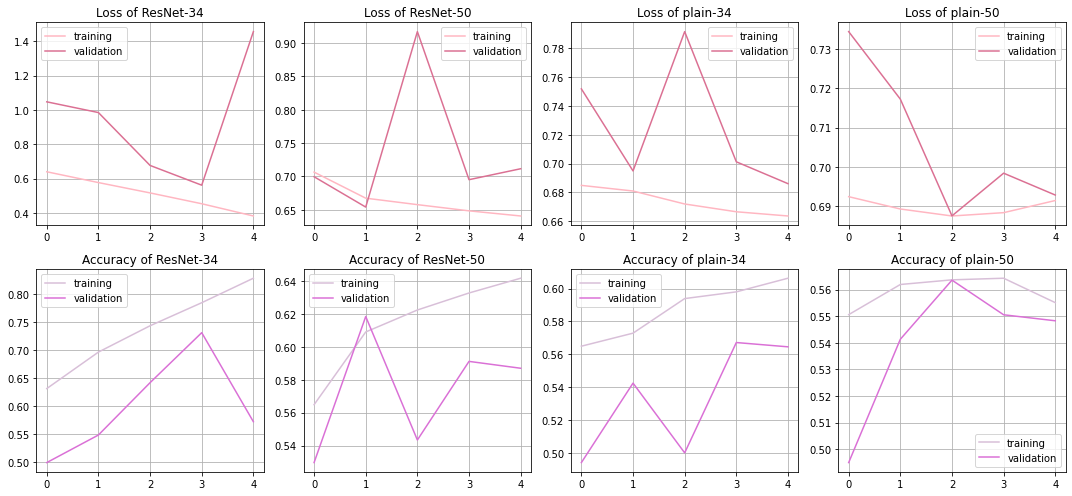

In [29]:
evaluate_4_models(experiments_dict)

**2-2. Compare loss & accuracy of between different models**

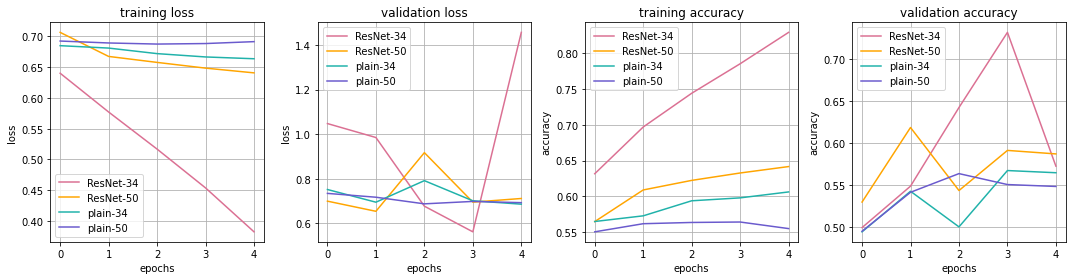

In [30]:
compare_4_models(experiments_dict)

**2-3. Evaluation**

- EPOCHS=5 밖에 되지 않기 때문에 크게 의미부여를 하기 어려울 것이다. 그럼에도 불구하고 굳이 그래프를 분석해본다면 loss 차원에서는 plain-50, accuracy 차원에서는 Res-Net34가 가장 좋은 성능을 보여주고 있다.

---
## <span style = "background-color: #FFFFDD"> 🍒 Conclusion</span>

**📝 회고록**  
- 아이펠을 시작한지 어언 두 달이 지났는데 직접 모델 코드 하나 짜지 못하는 게 부끄러워서💦 이번 프로젝트는 최소한의 참고자료만으로 직접 이틀동안 한땀한땀 손으로 짜봤다 😥 막상 완성하고 보니 인터넷에 돌아다니는 코드와 크게 다르지 않은 것 같지만... 그래도 스스로 너무 뿌듯하다 🥹💕 퀘스트 시간에 맞추지 못한 건 유감이지만... 한 점 부끄럼없이 열심히 했다 😭
- 퀘스트 시간에 쫓겨서 학습 EPOCHS=5 밖에 돌리지 못했다 😰 EPOCHS가 적은 만큼, 이번 프로젝트 실험 결과는 다소 무의미한 것 같다. 직접 모델을 구현하고 ablation study 실습을 설계했다는 데에 의의를 둬야지!

---